## Importing the necessary libraries

In [1]:
import os
import time
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image
from keras.models import Sequential
from keras.layers import Conv2D, SeparableConv2D, MaxPool2D, Flatten, Dense, InputLayer, BatchNormalization, Dropout
from tensorflow.keras.applications import MobileNet, MobileNetV2
from keras.callbacks import ModelCheckpoint, EarlyStopping

Reading the train categories from the file train.csv

In [2]:
train_labels = pd.read_csv('../input/game-of-deep-learning-ship-datasets/train/train.csv')
train_labels['category'] = train_labels['category'] - 1
train_labels.head()

,image,category
0,2823080.jpg,0
1,2870024.jpg,0
2,2662125.jpg,1
3,2900420.jpg,2
4,2804883.jpg,1


Reading the images from the train folder

In [3]:
X = []
y = []
path = "../input/game-of-deep-learning-ship-datasets/train/images/"
img_shape = 128
for i in train_labels.iterrows() :
    img_path = os.path.join(path, i[1]['image'])
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(img_shape,img_shape), interpolation='lanczos')
    img = tf.keras.preprocessing.image.img_to_array(img)
    X.append(img)
    y.append(float(i[1]['category']))
X = np.asarray(X)
y = np.asarray(y)
X.shape, y.shape

((6252, 128, 128, 3), (6252,))

In [4]:
im = Image.open('../input/game-of-deep-learning-ship-datasets/train/images/299281.jpg')
im.size

(210, 146)

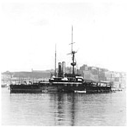

In [5]:
im.resize((128,128))

In [6]:
X = X / 255.0

Displaying a random image

Text(0.5, 1.0, '4.0')

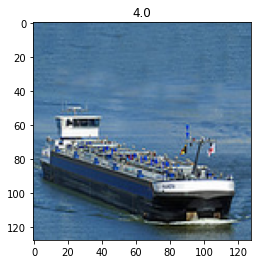

In [7]:
plt.imshow(X[1000])
plt.title(y[1000])

# Defining labels for prediction

In [8]:
labels_inv = {'Cargo': 0,
              'Military': 1,
              'Carrier': 2,
              'Cruise': 3,
              'Tankers': 4}
labels = {v:k for k,v in labels_inv.items()}
labels

{0: 'Cargo', 1: 'Military', 2: 'Carrier', 3: 'Cruise', 4: 'Tankers'}

# Helper Function for Prediction

In [9]:
def predict(path, mod) :
    img = tf.keras.preprocessing.image.load_img(path, target_size=(img_shape,img_shape), interpolation='lanczos')
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = img / 255.0
    pred = mod.predict(np.array([img]))
    plt.imshow(img)
    pred_label = np.argsort(pred)
    for i in pred_label[0][-1:-3:-1] :
        print(f"{labels[i]} Ship : {pred[0][i]*100:0.2f} %")

First model using the MobileNet architecture

In [10]:
model_1 = Sequential()
model_1.add(InputLayer(input_shape=(128, 128, 3)))
model_1.add(MobileNetV2(include_top=False, weights='imagenet'))
model_1.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
model_1.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model_1.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model_1.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model_1.add(Flatten())
model_1.add(Dropout(0.6))
model_1.add(Dense(units=2048,activation="relu"))
model_1.add(Dense(5, activation='softmax'))

model_1.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(1e-4), metrics=['accuracy'])

model_1.summary()

2022-07-17 00:43:06.641049: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-17 00:43:06.744817: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-17 00:43:06.745686: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-17 00:43:06.747318: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

9420800/9406464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, None, None, 1280)  2257984   
_________________________________________________________________
conv2d (Conv2D)              (None, 4, 4, 64)          737344    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 2, 2, 64)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 2, 2, 128)         73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 1, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 128)               0         
___________________________________________________________

In [11]:
checkpoint = ModelCheckpoint("model_1.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq=1)
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, verbose=1, mode='auto')
start = time.time()
hist = model_1.fit(X, y, epochs=50, batch_size=64, validation_split=0.25, shuffle=True, callbacks=[checkpoint,early])
stop = time.time()
print(f"Evaluation Time: {stop - start}")

2022-07-17 00:43:10.749451: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 921894912 exceeds 10% of free system memory.
2022-07-17 00:43:11.690213: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 921894912 exceeds 10% of free system memory.
2022-07-17 00:43:12.365084: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-07-17 00:43:17.024333: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


74/74 [==============================] - 21s 137ms/step - loss: 1.2782 - accuracy: 0.4641 - val_loss: 1.1709 - val_accuracy: 0.5720
Epoch 2/50
74/74 [==============================] - 8s 112ms/step - loss: 0.5131 - accuracy: 0.8000 - val_loss: 1.2244 - val_accuracy: 0.6513
Epoch 3/50
74/74 [==============================] - 8s 110ms/step - loss: 0.2577 - accuracy: 0.9051 - val_loss: 1.3612 - val_accuracy: 0.6660
Epoch 4/50
74/74 [==============================] - 8s 110ms/step - loss: 0.1191 - accuracy: 0.9586 - val_loss: 2.0261 - val_accuracy: 0.6315
Epoch 5/50
74/74 [==============================] - 8s 111ms/step - loss: 0.0757 - accuracy: 0.9733 - val_loss: 1.3881 - val_accuracy: 0.7179
Epoch 6/50
74/74 [==============================] - 8s 111ms/step - loss: 0.0607 - accuracy: 0.9793 - val_loss: 1.1574 - val_accuracy: 0.7518
Epoch 7/50
74/74 [==============================] - 8s 111ms/step - loss: 0.0448 - accuracy: 0.9870 - val_loss: 0.9769 - val_accuracy: 0.7818
Epoch 8/50
74/74

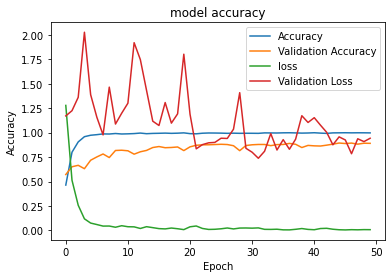

In [12]:
plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

In [13]:
model_1.evaluate(X,y)

2022-07-17 00:50:17.211937: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1229193216 exceeds 10% of free system memory.
2022-07-17 00:50:18.436551: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1229193216 exceeds 10% of free system memory.


196/196 [==============================] - 3s 15ms/step - loss: 0.2462 - accuracy: 0.9699


[0.24620580673217773, 0.9699296355247498]

Cargo Ship : 100.00 %
Military Ship : 0.00 %


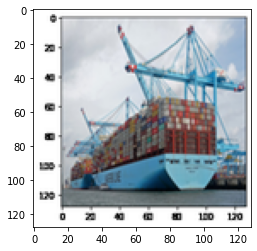

In [14]:
predict("../input/ship-test/test/cargo.png", model_1) # Cargo Ship Example from Internet

Doing prediction for some images taken from the internet

cargo.png
Cargo Ship : 100.00 %
Military Ship : 0.00 %
None
cruise.png
Cruise Ship : 100.00 %
Cargo Ship : 0.00 %
None
military.png
Military Ship : 99.99 %
Cruise Ship : 0.01 %
None
military1.png
Military Ship : 74.00 %
Cruise Ship : 25.89 %
None
tankers.png
Tankers Ship : 78.22 %
Cargo Ship : 21.78 %
None


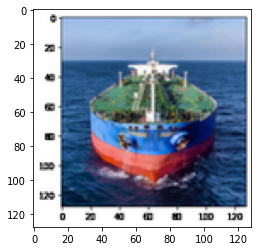

In [15]:
for filename in os.listdir("../input/ship-test/test/"):
    print(filename)
    print(predict("../input/ship-test/test/"+ filename, model_1))

Second model built using simplt Conv2D layers which is giving a god accuracy of 85%.

In [16]:
model = Sequential()
model.add(InputLayer(input_shape=(128, 128, 3)))
model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=1024, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=2048, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Flatten())
model.add(Dropout(0.6))
model.add(Dense(units=2048,activation="relu"))
model.add(Dense(5, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(1e-4), metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 128, 128, 64)      1792      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 256)       295168    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 512)      

In [17]:
checkpoint = ModelCheckpoint("model.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq=1)
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, verbose=1, mode='auto')
start = time.time()
hist = model.fit(X, y, epochs=150, batch_size=64, validation_split=0.25, shuffle=True, callbacks=[checkpoint,early])
stop = time.time()
print(f"Evaluation Time: {stop - start}")

2022-07-17 00:50:29.428680: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 921894912 exceeds 10% of free system memory.


Epoch 1/150
74/74 [==============================] - 9s 97ms/step - loss: 1.4980 - accuracy: 0.3589 - val_loss: 1.4153 - val_accuracy: 0.3980
Epoch 2/150
74/74 [==============================] - 5s 74ms/step - loss: 1.2407 - accuracy: 0.4628 - val_loss: 1.2566 - val_accuracy: 0.4229
Epoch 3/150
74/74 [==============================] - 5s 74ms/step - loss: 1.0253 - accuracy: 0.5632 - val_loss: 0.9121 - val_accuracy: 0.6200
Epoch 4/150
74/74 [==============================] - 5s 74ms/step - loss: 0.8755 - accuracy: 0.6353 - val_loss: 0.9360 - val_accuracy: 0.6212
Epoch 5/150
74/74 [==============================] - 6s 77ms/step - loss: 0.7681 - accuracy: 0.6844 - val_loss: 0.7491 - val_accuracy: 0.6910
Epoch 6/150
74/74 [==============================] - 5s 74ms/step - loss: 0.6560 - accuracy: 0.7385 - val_loss: 0.7706 - val_accuracy: 0.6731
Epoch 7/150
74/74 [==============================] - 6s 74ms/step - loss: 0.5656 - accuracy: 0.7665 - val_loss: 0.7250 - val_accuracy: 0.7242
Epoch 

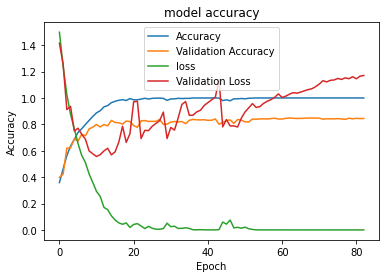

In [18]:
plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

In [19]:
model_1.evaluate(X,y)

196/196 [==============================] - 3s 15ms/step - loss: 0.2462 - accuracy: 0.9699


[0.24620580673217773, 0.9699296355247498]

cargo.png
Cargo Ship : 100.00 %
Cruise Ship : 0.00 %
None
cruise.png
Carrier Ship : 99.99 %
Cruise Ship : 0.01 %
None
military.png
Military Ship : 100.00 %
Tankers Ship : 0.00 %
None
military1.png
Military Ship : 85.81 %
Carrier Ship : 9.37 %
None
tankers.png
Cargo Ship : 98.56 %
Tankers Ship : 1.44 %
None


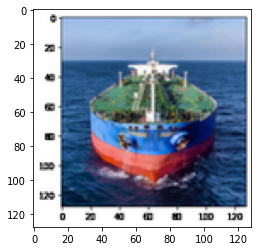

In [20]:
for filename in os.listdir("../input/ship-test/test/"):
    print(filename)
    print(predict("../input/ship-test/test/"+ filename, model))